In [1]:
import pickle
import os
import lc_model as model
import matplotlib.pyplot as plt
import numpy as np
from concurrent.futures import ProcessPoolExecutor
import parallel_simulation as sim

In [ ]:
# Parameters for the simulation
epoch = 960.0
sampling_rate = 1
num_simulations = 100000  # Adjust the number of simulations if needed
batch_size = 50  # Batch size for saving
VarDict = {
    "PSD_slope_fast": "fast_a1", "PSD_break_fast": "fast_b1",
    "mu_fast": "fast_mu", "sig_fast": "fast_sig", "PSD_slope_slow": "a1", "PSD_break_slow": "b1",
    "mu_slow": "mu", "sig_slow": "sig", "B_0": "B_0", "gamma": "gamma", "ampfac": "ampfac",
    "size_0": "size_0", "noise_NIR": "vlt_noise", "X_offset": "I_offset", "rate_conv": "rate_conv",
    "eff_area": "I_eff_area", "model_gain": "a", "f0_B": "f_0_B", "f0_theta": "f_0_size",
    "noise_345GHz": "APEX_noise", "noise_230GHz": "SMA_noise", "noise_340GHz": "APEX_noise"
}

# Run the parallel simulations with 4 workers
num_workers = 8
sim.Simulation.run_parallel_simulations(epoch, sampling_rate, VarDict, num_simulations, batch_size, num_workers)

No checkpoint found for worker 0. Starting from the beginning.No checkpoint found for worker 3. Starting from the beginning.No checkpoint found for worker 1. Starting from the beginning.No checkpoint found for worker 2. Starting from the beginning.



deleting 1000 data points with the following weights: 
[5.12923762e-02 4.04179702e-02 3.07697645e-02 3.06534026e-02
 2.36478802e-02 2.26434550e-02 2.22749958e-02 2.05187144e-02
 2.00421042e-02 1.91941454e-02 1.88873563e-02 1.80446011e-02
 1.77161173e-02 1.71729721e-02 1.63061639e-02 1.60983524e-02
 1.30807336e-02 1.09236823e-02 1.02315806e-02 9.94474245e-03
 8.51342682e-03 8.16572643e-03 7.46834531e-03 7.45059213e-03
 7.42389890e-03 7.14293716e-03 6.84056062e-03 6.80328251e-03
 6.69661934e-03 6.62010607e-03 6.50766927e-03 6.28457410e-03
 6.23052468e-03 5.93733657e-03 5.92201636e-03 5.82474903e-03
 5.63940968e-03 5.38609998e-03 4.87759561e-03 4.72130616e-03
 4.09845597e-03 4.00150057e-03 3.84011115e-03 3.74021843e-03
 3.64012778e-03 3.5927

600


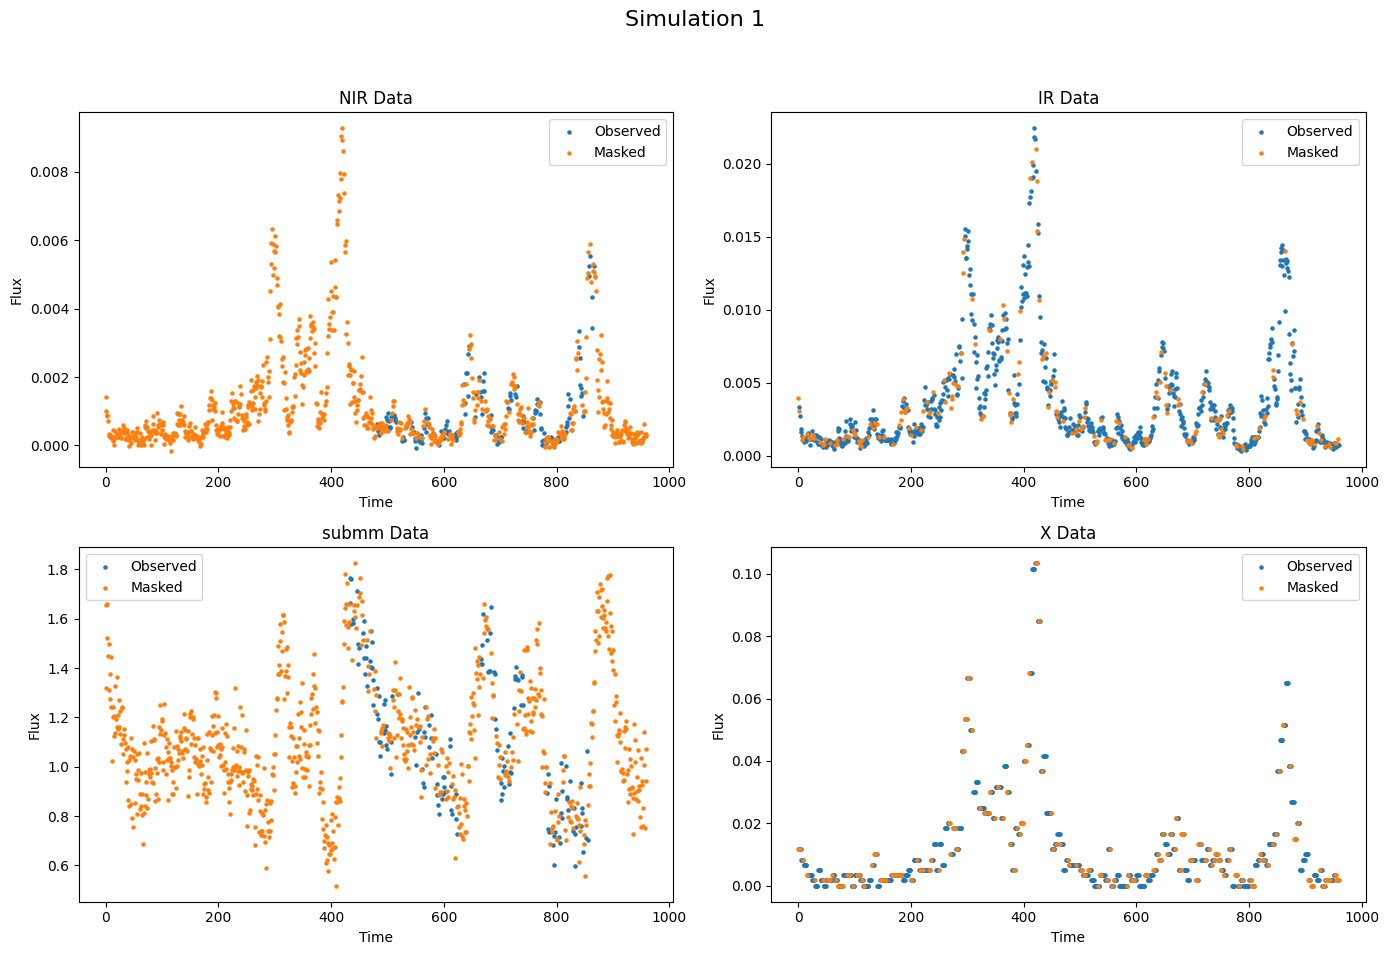

In [2]:
num_simulations = 150
batch_size = 50
num_batches = num_simulations // batch_size + (1 if num_simulations % batch_size != 0 else 0)

all_data = sim.Simulation.load_all_data(num_batches, 4)
print(len(all_data))
# len(all_data)
sim_number = 0
sim.Simulation.plot_simulation(all_data[sim_number]['data'], sim_number, 2)
# simulation.Simulation.plot_all_simulations(all_data)